### Ejercicio: Driving Under the Influence

La base `DUI.csv` cotiene información de `514` personas registrada en una zona de bares de la ciudad. Medimos dos variables: la `concentración de alcohol` en sangre, y si tienen un `accidente en automóvil` manejando esa misma noche.

1. Lee la base y haz explícitos los descriptivos generales.

2. Grafica `accidente` como función de `alcohol` y decide si la exploración visual sugiere una relación entre ambas variables.

3. Implementa **los dos** modelos logísticos que hemos estudiado, utilizando esta incertidumbre inicial sobre la *tasa* $a$ y sobre el *punto medio* $b$:

$$a\sim Gaussian(\mu=0,\sigma=10)$$

$$b\sim Gaussian(\mu=0.50,\sigma=0.10),$$

agregando incertidumbre inicial apropiada para la asíntota inferior $c$ y para la superior $d$ en el modelo de 4 parámetros.

4. Asegúrate de que las cadenas de `JAGS` muestren convergencia para cada modelo.

5. Grafica la distribución postdictiva **completa** para **cada modelo**, y decide cuál de los dos explica mejor las observaciones. Argumenta tu respuesta.

6. El nivel de `alcohol en sangre` más elevando en la base es 0.70, pero podría interesarnos hacer predicciones sobre un nivel de alcohol mayor, aunque todavía no lo hayamos observado. Implementa esta predicción en ambos modelos y haz explícito el resultado: ¿qué tan probable es tener un `accidente` para una persona que tenga `alcohol=0.90`, de acuerdo con **cada** modelo?

In [4]:
rm(list = ls())

In [5]:
data <- read.csv("data/DUI.csv")
head(data)
tail(data)
dim(data)
summary(data)

,alcohol_level,car_accident
,<dbl>,<int>
1,0.12,0
2,0.59,1
3,0.67,1
4,0.55,1
5,0.24,1
6,0.50,0


,alcohol_level,car_accident
,<dbl>,<int>
509,0.47,0
510,0.31,1
511,0.40,1
512,0.18,0
513,0.40,1
514,0.05,0


[1] 514   2

 alcohol_level     car_accident   
 Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.1500   1st Qu.:0.0000  
 Median :0.2600   Median :1.0000  
 Mean   :0.2806   Mean   :0.6479  
 3rd Qu.:0.4100   3rd Qu.:1.0000  
 Max.   :0.7000   Max.   :1.0000  

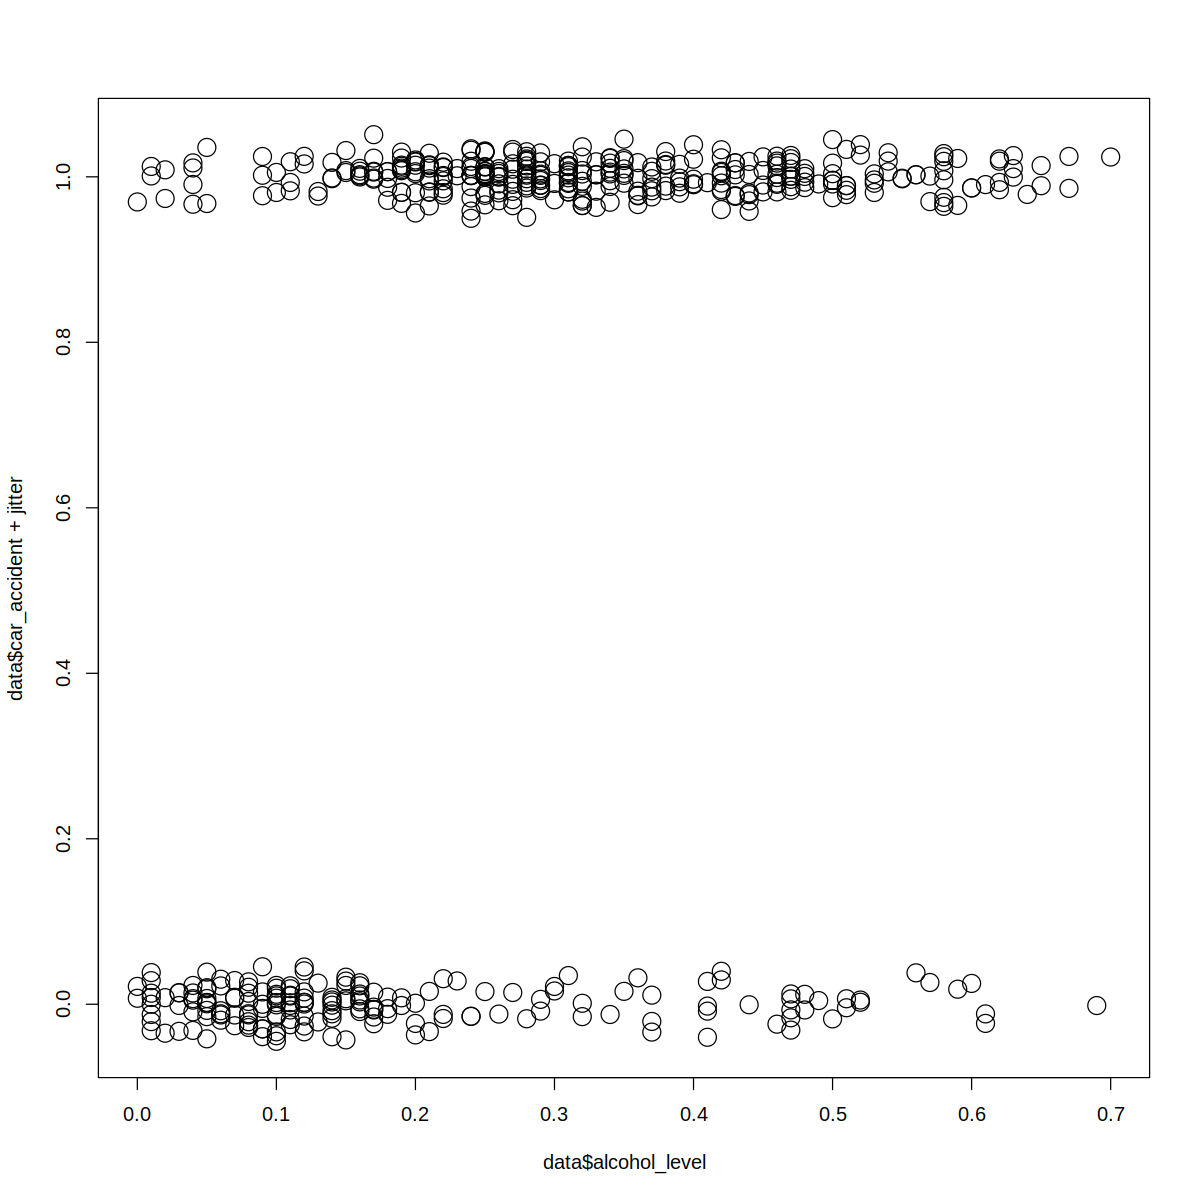

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)
jitter  <- rnorm(length(data$car_accident), mean = 0, sd = 0.02)
plot(data$alcohol_level, data$car_accident + jitter, cex = 2)

In [7]:
# 2PLM

# Observed
y <- data$car_accident
x <- data$alcohol_level

n_obs <- length(x)
data_jags <- list('x','y','n_obs')

# Unobserved
unobs_2plm <- c('a_post','a_prior',
           'b_post','b_prior',
           'theta_y_post','theta_y_prior',
           'y_postdict_post','y_postdict_prior')

# Model
write('model{

a_post~dnorm(0,0.01)
a_prior~dnorm(0,0.01)
b_post~dnorm(0.5,100)
b_prior~dnorm(0.5,100)
for(i in 1:n_obs){
    theta_y_post[i] <- 1/(1+exp(-a_post*(x[i]-b_post)))
    theta_y_prior[i] <- 1/(1+exp(-a_prior*(x[i]-b_prior)))
    y[i]~dbern(theta_y_post[i])
    y_postdict_post[i]~dbern(theta_y_post[i])
    y_postdict_prior[i]~dbern(theta_y_prior[i])
}

}
','two_parameter_logistic_regression.bug')

library('R2jags')
set.seed(18)
bayes_2plm <- jags(data=data_jags,
             parameters.to.save=unobs_2plm,
             model.file='two_parameter_logistic_regression.bug',
             n.chains=3,
             n.iter=30000,
             n.burnin=6000,
             n.thin=5)
nds_2pl <- bayes_2plm$BUGSoutput$sims.list
summary(bayes_2plm$BUGSoutput$summary[,'Rhat'])

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 514
   Unobserved stochastic nodes: 1032
   Total graph size: 2758

Initializing model



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.001   1.001   1.001   1.001   1.001   1.004 

In [8]:
# 4plm

# Unobserved
unobs_4plm <- c('a_post','a_prior',
                'b_post','b_prior',
                'c_post','c_prior',
                'd_post','d_prior',
                'theta_y_post','theta_y_prior',
                'y_postdict_post','y_postdict_prior')

# Model
write('model{

a_post~dnorm(0,0.01)
a_prior~dnorm(0,0.01)
b_post~dnorm(0.5,100)
b_prior~dnorm(0.5,100)
c_post~dunif(0,0.3)
c_prior~dunif(0,0.3)
d_post~dunif(0.75,1)
d_prior~dunif(0.75,1)

for(i in 1:n_obs){
    theta_y_post[i] <- c_post+(d_post-c_post)/(1+exp(-a_post*(x[i]-b_post)))
    theta_y_prior[i] <- c_prior+(d_prior-c_prior)/(1+exp(-a_prior*(x[i]-b_prior)))
    y[i]~dbern(theta_y_post[i])
    y_postdict_post[i]~dbern(theta_y_post[i])
    y_postdict_prior[i]~dbern(theta_y_prior[i])
}

}
','four_parameter_logistic_regression.bug')

bayes_4plm <- jags(data=data_jags,
             parameters.to.save=unobs_4plm,
             model.file='four_parameter_logistic_regression.bug',
             n.chains=3,
             n.iter=30000,
             n.burnin=6000,
             n.thin=5)
nds_4pl <- bayes_4plm$BUGSoutput$sims.list
summary(bayes_4plm$BUGSoutput$summary[,'Rhat'])

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 514
   Unobserved stochastic nodes: 1036
   Total graph size: 2904

Initializing model



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.001   1.001   1.001   1.001   1.001   1.002 

# Plots de las distribuciones postdictivas

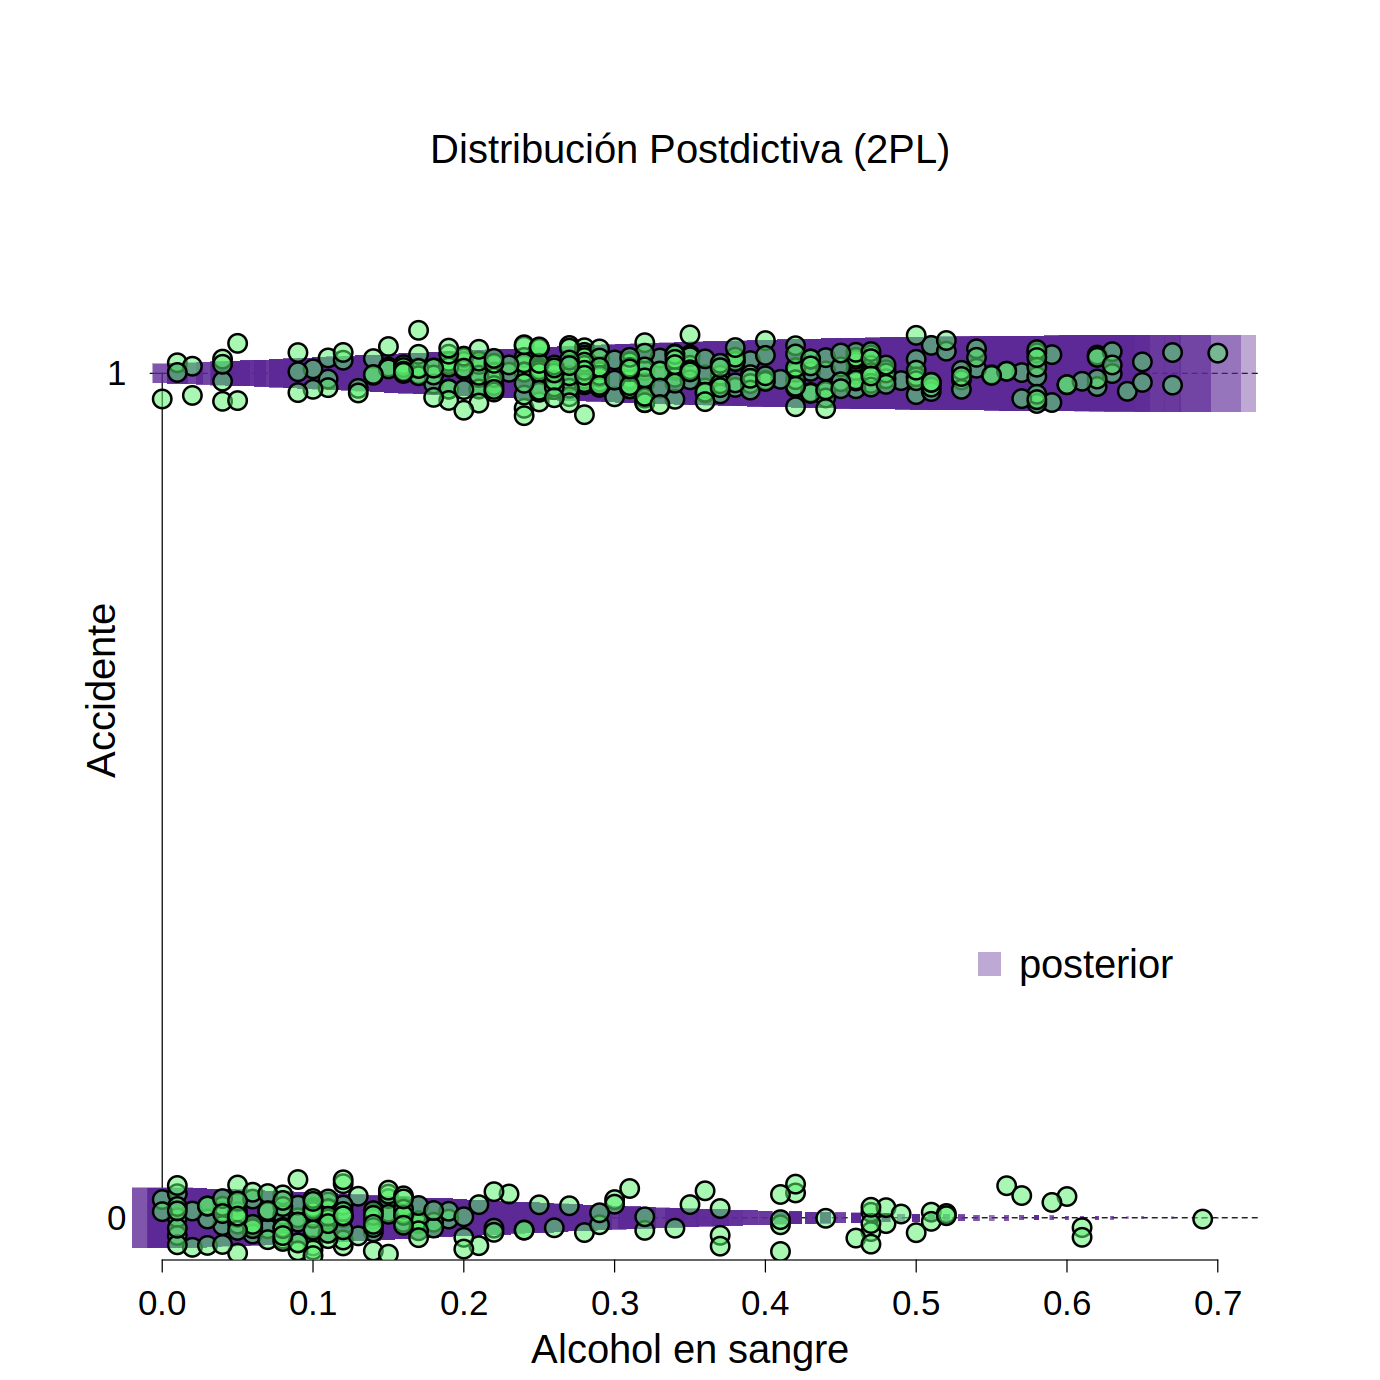

In [9]:
# 2PLM plot

col_prior <- '#daa4f9'
col_post <- '#5e2a96'
col_data <- '#5cf070'

options(repr.plot.width = 11.5, repr.plot.height = 11.5)
par(cex.axis=1.75,mgp=c(2,1.5,0),mar=rep(5,4))
plot(NULL,xlim=c(0,.7),ylim=c(0,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(1,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=0)
mtext('Alcohol en sangre',1,cex=2,line=3.5)
mtext('Accidente',2,cex=2,line=0)
mtext('Distribución Postdictiva (2PL)',3,cex=2,line=-2)
# Observation to highlight:
highlight <- 1:length(data$alcohol_level)
for(h in highlight){
    postdiction <- nds_2pl$y_postdict_post[,h]
    post_1 <- sum(postdiction)/length(postdiction)
    post_0 <- 1-post_1
    points(x=rep(data$alcohol_level[h],2),y=c(0,1),cex=c(post_0,post_1)*10,
           pch=22,bg=paste(col_post,'66',sep=''),col=NA)
}

legend(0.5,0.3,yjust=0.5,pt.cex=3,
       pch=22,pt.bg=paste(col_post,'66',sep=''),
       col=NA,legend=,'posterior',
       seg.len=.3,cex=2,x.intersp=.4,text.width=3,box.lty='blank',bg='#ffffff88')

points(data$alcohol_level, data$car_accident+jitter,cex=2.05,pch=21,bg=paste(col_data,'88',sep=''),lwd=2)

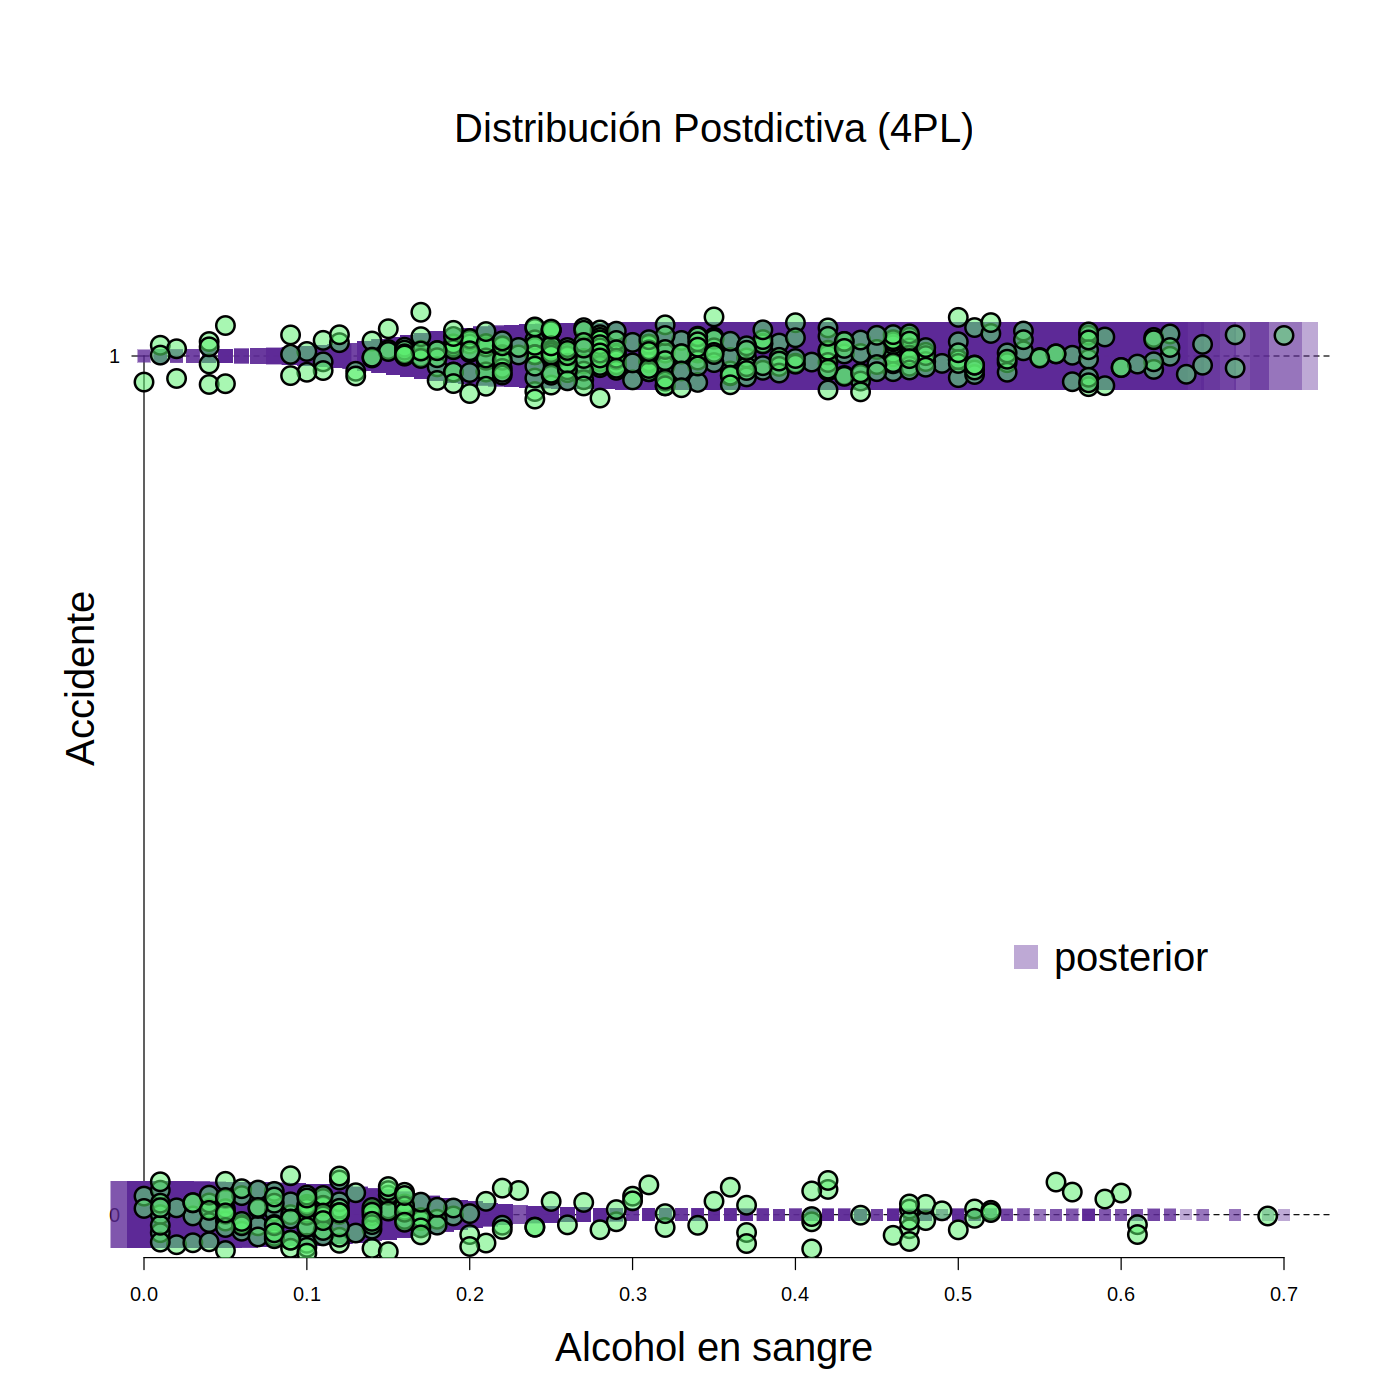

In [10]:
# 4PLM plot

plot(NULL,xlim=c(0,.7),ylim=c(0,1.25),axes=F,ann=F)
segments(x0=rep(0,2),x1=rep(1,2),y0=c(0,1),y1=c(0,1),lty='dashed')
axis(1)
axis(2,at=c(0,1),las=1,pos=0)
mtext('Alcohol en sangre',1,cex=2,line=3.5)
mtext('Accidente',2,cex=2,line=0)
mtext('Distribución Postdictiva (4PL)',3,cex=2,line=-2)
# Observation to highlight:
highlight <- 1:length(data$alcohol_level)
for(h in highlight){
    postdiction <- nds_4pl$y_postdict_post[,h]
    post_1 <- sum(postdiction)/length(postdiction)
    post_0 <- 1-post_1
    points(x=rep(data$alcohol_level[h],2),y=c(0,1),cex=c(post_0,post_1)*10,
           pch=22,bg=paste(col_post,'66',sep=''),col=NA)
}

legend(0.5,0.3,yjust=0.5,pt.cex=3,
       pch=22,pt.bg=paste(col_post,'66',sep=''),
       col=NA,legend=,'posterior',
       seg.len=.3,cex=2,x.intersp=.4,text.width=3,box.lty='blank',bg='#ffffff88')

points(data$alcohol_level, data$car_accident+jitter,cex=2.05,pch=21,bg=paste(col_data,'88',sep=''),lwd=2)

# Decisión entre los modelos

Basándonos en las distribuciones postdictivas de ambos modelos, el modelo de 4 parámetros parece explicar mejor los datos, pues en los valores de alcohol en sangre mayores a 0.6 y sin un accidente, aún tiene observaciones, con baja probabilidad, pero las tiene, a diferencia del modelo de 2 parámetros donde ya no hay ninguna en esos valores de alcohol en sangre.

# Predicción de alcohol en sangre de 0.90

In [11]:
# 2PLM prediction

# Observed
y <- data$car_accident
x <- data$alcohol_level

# Target prediction
x_target  <- c(0.90)
n_target  <- length(x_target)

n_obs <- length(x)
data_jags <- list('x','y','n_obs', 'x_target', 'n_target')

# Unobserved
unobs_2plm_pred <- c('a_post','a_prior',
                'b_post','b_prior',
                'theta_y_post','theta_y_prior',
                'theta_y_target_post', 'theta_y_target_prior',
                'y_postdict_target_post', 'y_postdict_target_prior',
                'y_postdict_post','y_postdict_prior')

# Model
write('model{

a_post~dnorm(0,0.01)
a_prior~dnorm(0,0.01)
b_post~dnorm(0.5,100)
b_prior~dnorm(0.5,100)
for(i in 1:n_obs){
    theta_y_post[i] <- 1/(1+exp(-a_post*(x[i]-b_post)))
    theta_y_prior[i] <- 1/(1+exp(-a_prior*(x[i]-b_prior)))
    y[i]~dbern(theta_y_post[i])
    y_postdict_post[i]~dbern(theta_y_post[i])
    y_postdict_prior[i]~dbern(theta_y_prior[i])
}

# Prediction at x_target
for(j in 1:n_target){
    theta_y_target_post[j] <- 1/(1+exp(-a_post*(x_target[j]-b_post)))
    theta_y_target_prior[j] <- 1/(1+exp(-a_prior*(x_target[j]-b_prior)))
    y_postdict_target_post[j]~dbern(theta_y_target_post[j])
    y_postdict_target_prior[j]~dbern(theta_y_target_prior[j])
}

}
','two_parameter_logistic_regression_prediction.bug')

bayes_2plm_pred <- jags(data=data_jags,
             parameters.to.save=unobs_2plm_pred,
             model.file='two_parameter_logistic_regression_prediction.bug',
             n.chains=3,
             n.iter=30000,
             n.burnin=6000,
             n.thin=5)
nds_2pl_pred <- bayes_2plm_pred$BUGSoutput$sims.list
summary(bayes_2plm_pred$BUGSoutput$summary[,'Rhat'])

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 514
   Unobserved stochastic nodes: 1034
   Total graph size: 2772

Initializing model



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.001   1.001   1.001   1.001   1.001   1.008 

In [13]:
# 4PLM prediction

# Unobserved
unobs_2plm_pred <- c('a_post','a_prior',
                'b_post','b_prior',
                'c_post', 'c_prior',
                'd_post', 'd_prior',
                'theta_y_post','theta_y_prior',
                'y_postdict_post','y_postdict_prior',
                'theta_y_target_post', 'theta_y_target_prior',
                'y_postdict_target_post', 'y_postdict_target_prior')

# Model
write('model{

a_post~dnorm(0,0.01)
a_prior~dnorm(0,0.01)
b_post~dnorm(0.5,100)
b_prior~dnorm(0.5,100)
c_post~dunif(0,0.3)
c_prior~dunif(0,0.3)
d_post~dunif(0.75,1)
d_prior~dunif(0.75,1)

for(i in 1:n_obs){
    theta_y_post[i] <- c_post+(d_post-c_post)/(1+exp(-a_post*(x[i]-b_post)))
    theta_y_prior[i] <- c_prior+(d_prior-c_prior)/(1+exp(-a_prior*(x[i]-b_prior)))
    y[i]~dbern(theta_y_post[i])
    y_postdict_post[i]~dbern(theta_y_post[i])
    y_postdict_prior[i]~dbern(theta_y_prior[i])
}

# Prediction at x_target
for(j in 1:n_target){
    theta_y_target_post[j] <- c_post+(d_post-c_post)/(1+exp(-a_post*(x_target[j]-b_post)))
    theta_y_target_prior[j] <- c_prior+(d_prior-c_prior)/(1+exp(-a_prior*(x_target[j]-b_prior)))
    y_postdict_target_post[j]~dbern(theta_y_target_post[j])
    y_postdict_target_prior[j]~dbern(theta_y_target_prior[j])
}

}
','four_parameter_logistic_regression_prediction.bug')

bayes_4plm_pred <- jags(data=data_jags,
             parameters.to.save=unobs_2plm_pred,
             model.file='four_parameter_logistic_regression_prediction.bug',
             n.chains=3,
             n.iter=30000,
             n.burnin=6000,
             n.thin=5)
nds_4pl_pred <- bayes_4plm_pred$BUGSoutput$sims.list
summary(bayes_4plm_pred$BUGSoutput$summary[,'Rhat'])

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 514
   Unobserved stochastic nodes: 1038
   Total graph size: 2920

Initializing model



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.001   1.001   1.001   1.001   1.001   1.002 

# Resultados

In [25]:
prediction_2plm <- bayes_2plm_pred$BUGSoutput$summary["y_postdict_target_post",]
prediction_4plm <- bayes_4plm_pred$BUGSoutput$summary["y_postdict_target_post",]

results  <- data.frame(
    mean = double(),
    sd = double(),
    "2.5%" = double(),
    "25%" = double(),
    "50%" = double(),
    "75%" = double(),
    "97.5%" = double(),
    Rhat = double(),
    n.eff = double()
)
results[1, ]  <- prediction_2plm
results[2, ] <- prediction_4plm
rownames(results) <- c("Predicción 2PLM", "Predicción 4PLM")

results

,mean,sd,X2.5.,X25.,X50.,X75.,X97.5.,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Predicción 2PLM,0.9927083,0.08508232,1,1,1,1,1,1.007675,8800
Predicción 4PLM,0.8516667,0.35544244,0,1,1,1,1,1.000921,14000
